# Slide model with nonlinear return mapping

In [1]:
import sympy as sp
sp.init_printing()
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from mayavi import mlab
import os.path

home_dir = os.path.expanduser('~')
#mlab.init_notebook()

 * Unresolved functions like back stress. It would be possible to define the state variable as time dependent functions from the very beginning - directly in the potential definition. Then. composed functions, like the thermodynamic forces would have the 
 * Implementation for multidimensional arguments - separation of elastic and inelastic material parameters within the domain - 
 * Algorithmic stiffness ... try to construct the derivative with respect to the total slip.
 * Skewness of the level set function in the kinematic space - check. 
 * Rule for the signs of the potential gradients - how to get it automatically
 * non-associated to associated?
 * two-dimensional interface
 * interaction with lateral damage
- Interaction between normal and tangential
- Evaluation of energy dissipation for individual mechanisms


## Material parameters

In [2]:
E_b = sp.Symbol('E_b', real=True, nonnegative=True)
gamma = sp.Symbol('gamma', real=True)
K = sp.Symbol('K', real=True)
S = sp.Symbol('S', real=True)
r = sp.Symbol('r', real=True)
c = sp.Symbol('c', real=True)
tau_bar = sp.Symbol(r'\bar{\tau}', real=True, nonnegative=True)
m = sp.Symbol('m', real=True)

## Control parameter

In [3]:
sigma_N = sp.Symbol('sigma_N', real=True)

## State variables

In [4]:
s = sp.Symbol('s', real=True)
omega = sp.Symbol('omega', real=True, nonnegative=True)
omega.is_nonnegative
s_pi = sp.Symbol(r's_pi', real=True)
alpha = sp.Symbol('alpha', real=True)
z = sp.Symbol('z', real=True)
SV = sp.Matrix([s_pi, alpha, z, omega])
SV

⎡sₚᵢ⎤
⎢   ⎥
⎢ α ⎥
⎢   ⎥
⎢ z ⎥
⎢   ⎥
⎣ ω ⎦

In [5]:
dot_lambda = sp.Symbol(r'\dot{\lambda}', real=True, nonnegative=True)

In [6]:
rho_phi = sp.Rational(1,2)* ( (1-omega)*E_b*(s-s_pi)**2 + gamma * alpha**2 + K * z**2)
rho_phi

## Thermodynamic forces

In [7]:
tau = sp.Symbol('tau', real=True)
tau_pi = sp.Symbol(r'tau_pi', real=True)
X = sp.Symbol('X', real=True)
Z = sp.Symbol('Z', real=True, nonnegative=True)
Y = sp.Symbol('Y', real=True)
TF = [tau_pi, X, Z, Y] 
TF

## Threshold 

Define effective stresses as a function of the apparent stress and damage.  Note that $\tau_\pi = \tau$.

In [8]:
tau_eff = sp.Function(r'\tau^{\mathrm{eff}}')(tau_pi, omega)
Q = sp.Function('Q')(tau_eff,X)
tau_eff

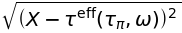

In [9]:
norm_Q = sp.sqrt(Q*Q)
sp.simplify(norm_Q.subs(Q,tau_eff-X))

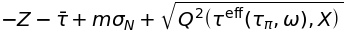

In [10]:
f = norm_Q - Z - tau_bar + m * sigma_N 
f

In [99]:
subs_Q = {Q: tau_eff - X}
subs_Q

In [12]:
subs_tau_eff = {tau_eff: tau_pi / (1-omega)}

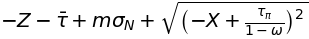

In [13]:
f_TF = f.subs(subs_Q).subs(subs_tau_eff)
f_TF

In [14]:
grad_f = sp.Matrix([ f.diff(tf) for tf in  TF ])
grad_f

⎡   _____________________________________                                     
⎢  ╱  2                                                 ∂                     
⎢╲╱  Q (\tau__{\mathrm{eff}}(τₚᵢ, ω), X) ⋅─────────────────────────────(Q(\tau
⎢                                         ∂\tau__{\mathrm{eff}}(τₚᵢ, ω)       
⎢─────────────────────────────────────────────────────────────────────────────
⎢                                                      Q(\tau__{\mathrm{eff}}(
⎢                                                                             
⎢                                  _____________________________________      
⎢                                 ╱  2                                   ∂    
⎢                               ╲╱  Q (\tau__{\mathrm{eff}}(τₚᵢ, ω), X) ⋅──(Q(
⎢                                                                        ∂X   
⎢                               ──────────────────────────────────────────────
⎢                                                   

In [15]:
grad_f_TF = grad_f.subs(subs_Q).subs(subs_tau_eff).doit()
grad_f_TF

⎡      _______________ ⎤
⎢     ╱             2  ⎥
⎢    ╱  ⎛      τₚᵢ ⎞   ⎥
⎢   ╱   ⎜-X + ─────⎟   ⎥
⎢ ╲╱    ⎝     1 - ω⎠   ⎥
⎢ ──────────────────── ⎥
⎢         ⎛      τₚᵢ ⎞ ⎥
⎢ (1 - ω)⋅⎜-X + ─────⎟ ⎥
⎢         ⎝     1 - ω⎠ ⎥
⎢                      ⎥
⎢      _______________ ⎥
⎢     ╱             2  ⎥
⎢    ╱  ⎛      τₚᵢ ⎞   ⎥
⎢-  ╱   ⎜-X + ─────⎟   ⎥
⎢ ╲╱    ⎝     1 - ω⎠   ⎥
⎢──────────────────────⎥
⎢            τₚᵢ       ⎥
⎢      -X + ─────      ⎥
⎢           1 - ω      ⎥
⎢                      ⎥
⎢          -1          ⎥
⎢                      ⎥
⎣          0           ⎦

**Plot the threshold function**: for changing damage $\omega \in (0,1)$. 

In [16]:
def anim_levelset(get_f,
                  xrange=(-30,30), yrange=(-30, 30), zrange=(-30,30), trange=(0,1),
                  labels=['x','y','z'] ):
    xmin, xmax = xrange
    ymin, ymax = yrange
    zmin, zmax = zrange
    tmin, tmax = trange
    grid_args = np.mgrid[xmin:xmax:80j, ymin:ymax:80j, zmin:zmax:80j]
    f_args = tuple(grid_args)+(0.00001,)
    f_val = get_f(*f_args)
    contour = mlab.contour3d(
        *tuple(grid_args) + (f_val,),
        contours=[0.0], color=(1, 0, 0)
    )
    xl, yl, zl = labels
    mlab.axes(xlabel=xl, ylabel=yl, zlabel=zl)
    @mlab.animate
    def anim():
        for omega_val in np.linspace(tmin,tmax,100):
            contour.mlab_source.scalars = get_f(*tuple(grid_args)+(omega_val,))
            yield

    anim()
    mlab.show()

In [17]:
if False:
    subs_f_TF_data = ({m:0, tau_bar:10})
    get_f = sp.lambdify(
        (tau_pi, X, Z, omega), 
        f_TF.subs(subs_f_TF_data), 'numpy')
    anim_levelset(get_f)

## Flow potential

In [18]:
Psi = sp.Function('\Psi')(Y,omega)

In [19]:
subs_Psi = {Psi: S* (1-omega)**c / (r+1) * (Y/S)**(r+1)}

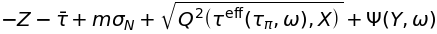

In [20]:
psi = f + Psi
psi

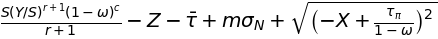

In [21]:
psi_TF = psi.subs(subs_Q).subs(subs_tau_eff).subs(subs_Psi)
psi_TF

In [22]:
if False:
    subs_psi_data = {tau_bar:10, m:0, S:5, r:1, c:1, Z:0}
    get_psi = sp.lambdify(
        [tau_pi, X, Y, omega],
        psi_TF.subs(subs_psi_data), 'numpy')
    anim_levelset(get_psi, zrange=(-10,10))

In [23]:
signs = sp.diag(1,1,1,1)
grad_psi = signs * sp.Matrix([psi.diff(tf) for tf in TF])
grad_psi_TF = grad_psi.subs(subs_Q).subs(subs_tau_eff).subs(subs_Psi).doit()
grad_psi_TF

⎡      _______________ ⎤
⎢     ╱             2  ⎥
⎢    ╱  ⎛      τₚᵢ ⎞   ⎥
⎢   ╱   ⎜-X + ─────⎟   ⎥
⎢ ╲╱    ⎝     1 - ω⎠   ⎥
⎢ ──────────────────── ⎥
⎢         ⎛      τₚᵢ ⎞ ⎥
⎢ (1 - ω)⋅⎜-X + ─────⎟ ⎥
⎢         ⎝     1 - ω⎠ ⎥
⎢                      ⎥
⎢      _______________ ⎥
⎢     ╱             2  ⎥
⎢    ╱  ⎛      τₚᵢ ⎞   ⎥
⎢-  ╱   ⎜-X + ─────⎟   ⎥
⎢ ╲╱    ⎝     1 - ω⎠   ⎥
⎢──────────────────────⎥
⎢            τₚᵢ       ⎥
⎢      -X + ─────      ⎥
⎢           1 - ω      ⎥
⎢                      ⎥
⎢          -1          ⎥
⎢                      ⎥
⎢      r + 1           ⎥
⎢   ⎛Y⎞             c  ⎥
⎢ S⋅⎜─⎟     ⋅(1 - ω)   ⎥
⎢   ⎝S⎠                ⎥
⎢ ───────────────────  ⎥
⎣          Y           ⎦

In [24]:
subs_d_psi_TF = {var: val for var, val in zip(TF, grad_psi_TF)}

In [25]:
def anim_quiver3d(get_f, get_grad_f,
                  xrange=(-30,30), yrange=(-30, 30), zrange=(-30,30), trange=(0,1),
                  labels=['x','y','z'] ):
    xmin, xmax = xrange
    ymin, ymax = yrange
    zmin, zmax = zrange
    tmin, tmax = trange
    grid_args = np.mgrid[xmin:xmax:20j, ymin:ymax:20j, zmin:zmax:20j]
    f_args = tuple(grid_args)+(tmin,)
    f_val = get_f(*f_args)
    f_contour = mlab.contour3d(
        *tuple(grid_args) + (f_val,),
        contours=[0.0], color=(0, 1, 0)
    )
    x, y, z = grid_args
    psi_val = get_grad_f(*f_args)
    u, v, w = psi_val[(0,1,3),0]
    quiver = mlab.quiver3d(x,y,z,u,v,w)

    xl, yl, zl = labels 
    mlab.axes(xlabel=xl, ylabel=yl, zlabel=zl)
    @mlab.animate
    def anim():
        for omega_val in np.linspace(tmin,tmax,100):
            f_args = tuple(grid_args)+(omega_val,)
            f_contour.mlab_source.scalars = get_f(*f_args)
            psi_val = get_grad_f(*f_args)
            u, v, w = psi_val[(0,1,3),0]
            quiver.mlab_source.u = u
            quiver.mlab_source.v = v
            quiver.mlab_source.w = w
            yield

    anim()
    mlab.show()

In [26]:
if False:
    subs_psi_data = {tau_bar:10, m:0, S:5, r:1, c:1, Z:0}
    get_psi = sp.lambdify(
        (tau_pi, X, Y, omega), 
        psi_TF.subs(subs_psi_data), 'numpy')
    get_grad_psi = sp.lambdify(
        [tau_pi, X, Y, omega], 
        grad_psi_TF.subs(subs_psi_data), 'numpy')
    anim_quiver3d(get_psi, get_grad_psi, 
                  xrange=(-30,30), yrange=(-30,30), zrange=(-5,5), trange=(0.001, 0.1))

## Thermodynamic forces

In [27]:
rho_phi

In [28]:
signs = sp.diag(-1,1,1,-1)
grad_rho_phi = sp.Matrix([rho_phi.diff(sv) for sv in SV])
subs_TF = {
  var: val for var,val in zip(TF,signs*grad_rho_phi)
}
subs_TF

In [29]:
TF_SV = grad_rho_phi
TF_SV

⎡E_b⋅(1 - ω)⋅(-2⋅s + 2⋅sₚᵢ)⎤
⎢──────────────────────────⎥
⎢            2             ⎥
⎢                          ⎥
⎢           α⋅γ            ⎥
⎢                          ⎥
⎢           K⋅z            ⎥
⎢                          ⎥
⎢                   2      ⎥
⎢     -E_b⋅(s - sₚᵢ)       ⎥
⎢     ────────────────     ⎥
⎣            2             ⎦

In [30]:
f_SV = f_TF.subs(subs_TF)
f_SV

Flow potential expressed in terms of the kinematic state variables

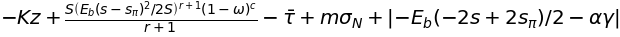

In [31]:
psi_SV = psi_TF.subs(subs_TF)
psi_SV

In [32]:
signs

⎡-1  0  0  0 ⎤
⎢            ⎥
⎢0   1  0  0 ⎥
⎢            ⎥
⎢0   0  1  0 ⎥
⎢            ⎥
⎣0   0  0  -1⎦

In [33]:
if False:
    subs_psi_SV_data = {K:0.0001, S:0.0001, r:0.1, c:3, m:0, E_b:1, s:0, gamma:1, tau_bar:1}
    get_psi_SV = sp.lambdify(
        (s_pi, alpha, z, omega), 
        psi_SV.subs(subs_psi_SV_data), 'numpy')
    grad_psi_SV = signs * grad_psi_TF.subs(subs_TF)
    get_grad_psi_SV = sp.lambdify(
        (s_pi, alpha, z, omega), 
        grad_psi_SV.subs(subs_psi_SV_data), 'numpy')
    anim_quiver3d(get_psi_SV, get_grad_psi_SV, 
                  xrange=(-3,3), yrange=(-3,3), zrange=(-3,3),
                  trange=(0,0.1))

## Evolution equations

**Rates of state variables:**

In [101]:
dot_s, t = sp.symbols(r'\dot{s}, t')
dot_s

In [103]:
s_t = sp.Function(r's')(t)
s_pi_t = sp.Function(r's_pi')(t)
alpha_t = sp.Function(r'alpha')(t)
z_t = sp.Function(r'z')(t)
omega_t = sp.Function(r'omega')(t)
alpha_t

In [36]:
def var_timify( var ):
    return sp.Function(var.name+'_t')(t)
def var_dotify( var ):
    return sp.Symbol(r'\dot{%s}' % var)

In [37]:
subs_SV_t = {
    var_timify(var) : var for var in SV
}
subs_SV_t

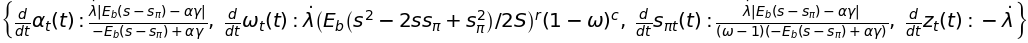

In [38]:
dot_SV_t = dot_lambda * grad_psi_TF.subs(subs_TF)
subs_dot_SV_t = {
    var_timify(var).diff(t): sp.simplify(val) 
    for var, val in zip(SV, dot_SV_t)
}
subs_dot_SV_t

## Rates of thermodynamic forces

In [39]:
subs_timify = {var: var_timify(var)
              for var in list(SV) + [s]}
subs_untimify = {var_timify(var): var
              for var in list(SV)}
subs_timify, subs_untimify

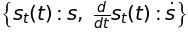

In [104]:
dot_s = sp.Symbol(r'\dot{s}')
subs_s_untimify = {var_timify(s):s, var_timify(s).diff(t): dot_s} 
subs_s_untimify

In [41]:
dot_TF = sp.Matrix([
    subs_TF[tf].subs(subs_timify).diff(t)
    for tf in TF ])
dot_TF

⎡                  ⎛  d                d        ⎞                             
⎢  E_b⋅(1 - ωₜ(t))⋅⎜2⋅──(sₚᵢ ₜ(t)) - 2⋅──(sₜ(t))⎟   E_b⋅(2⋅sₚᵢ ₜ(t) - 2⋅sₜ(t))
⎢                  ⎝  dt               dt       ⎠                             
⎢- ────────────────────────────────────────────── + ──────────────────────────
⎢                        2                                           2        
⎢                                                                             
⎢                                        d                                    
⎢                                      γ⋅──(αₜ(t))                            
⎢                                        dt                                   
⎢                                                                             
⎢                                        d                                    
⎢                                      K⋅──(zₜ(t))                            
⎢                                        dt         

In [42]:
dot_TF_SV = sp.Matrix([
    subs_TF[tf].subs(subs_timify).diff(t).subs(
        subs_dot_SV_t).subs(subs_untimify).subs(subs_s_untimify)
    for tf in TF ])
dot_TF_SV

⎡                                             r                               
⎢                  ⎛    ⎛ 2                2⎞⎞                                
⎢                  ⎜E_b⋅⎝s  - 2⋅s⋅sₚᵢ + sₚᵢ ⎠⎟         c                      
⎢E_b⋅\dot{\lambda}⋅⎜─────────────────────────⎟ ⋅(1 - ω) ⋅(-2⋅s + 2⋅sₚᵢ)   E_b⋅
⎢                  ⎝           2⋅S           ⎠                                
⎢────────────────────────────────────────────────────────────────────── - ────
⎢                                  2                                          
⎢                                                                             
⎢                                                 \dot{\lambda}⋅γ⋅│E_b⋅(s - sₚ
⎢                                                 ────────────────────────────
⎢                                                          -E_b⋅(s - sₚᵢ) + α⋅
⎢                                                                             
⎢                                                   

## Consistency condition

In [43]:
dot_f = sp.simplify((grad_f_TF.subs(subs_TF).T * dot_TF_SV)[0,0])

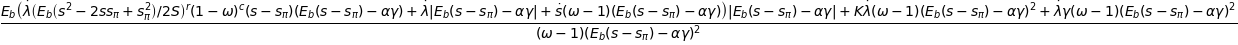

In [44]:
dot_f

## Return mapping expression

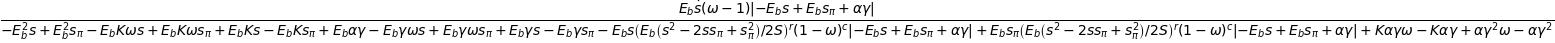

In [45]:
dot_lambda_solved = sp.solve(dot_f, dot_lambda)[0]
dot_lambda_simplified = sp.simplify(dot_lambda_solved)
dot_lambda_simplified

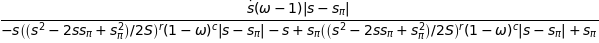

In [46]:
data_dict = {E_b:1, K:0, gamma:0} #              gamma:1, K:1, S:1, r:1, c:1, m:1, tau_bar:1, sigma_N : 0}
dot_lambda_solved.subs(data_dict)

In [47]:
sp.simplify(dot_TF_SV.subs(dot_lambda, dot_lambda_solved).subs(data_dict))

⎡                             0                             ⎤
⎢                                                           ⎥
⎢                             0                             ⎥
⎢                                                           ⎥
⎢                             0                             ⎥
⎢                                                           ⎥
⎢                             r                             ⎥
⎢        ⎛ 2                2⎞                              ⎥
⎢        ⎜s  - 2⋅s⋅sₚᵢ + sₚᵢ ⎟         c                    ⎥
⎢\dot{s}⋅⎜───────────────────⎟ ⋅(1 - ω) ⋅(s - sₚᵢ)⋅│s - sₚᵢ│⎥
⎢        ⎝        2⋅S        ⎠                              ⎥
⎢───────────────────────────────────────────────────────────⎥
⎢                            r                              ⎥
⎢       ⎛ 2                2⎞                               ⎥
⎢       ⎜s  - 2⋅s⋅sₚᵢ + sₚᵢ ⎟         c                     ⎥
⎢       ⎜───────────────────⎟ ⋅(1 - ω) ⋅│s - sₚᵢ│ + 1       ⎥
⎣       

In [48]:
sp.simplify(dot_f.subs(dot_lambda, dot_lambda_solved))

## Test of consistency recovery

In [49]:
data_dict = {E_b:1, gamma:1, K:1, S:1, r:1, c:1, m:1, tau_bar:1, sigma_N : 0}

In [50]:
state_dict = {s:5, alpha:0, z:0, s_pi:1, omega:sp.Rational(1,2) }

In [51]:
dot_lambda_test = dot_lambda_solved.subs(data_dict).subs(state_dict)
dot_lambda_test

In [52]:
sp.simplify(dot_f.subs(data_dict).subs(state_dict).subs(dot_lambda, dot_lambda_test))

In [53]:
from sympy.utilities.codegen import codegen

In [54]:
#codegen(('dot_lambda', dot_lambda_state),'C89')

In [55]:
#sp.lambdify(omega, dot_lambda_state,'numpy');

# Time integration scheme

In [77]:
material_params = {
    E_b:1, 
#    gamma:0, K:0, 
    gamma:0.2, K:0.1, 
#    S:0, r:0.001, c:1, 
    S:0.006, r:0.001, c:1, 
    tau_bar:1, 
    m:0.1,
    sigma_N:1
}

## Discrete evolution equations

In [107]:
s_pi_n, z_n, alpha_n = sp.symbols(
    r's_pi_n, z_n, alpha_n', real=True)
omega_n, omega_k = sp.symbols(
    r'omega_n, omega_k', real=True, nonnegative=True)
s_pi_k, z_k, alpha_k = sp.symbols(
    r's_pi_k, z_k, alpha_k', real=True)
dlambda_ = sp.Symbol('lambda_Delta', nonnegative=True)
subs_state_n = {s_pi: s_pi_n, alpha: alpha_n, omega: omega_n, z: z_n }
subs_state_k = {s_pi: s_pi_k, alpha: alpha_k, omega: omega_k, z: z_k }

**Discrete evolution equatins**

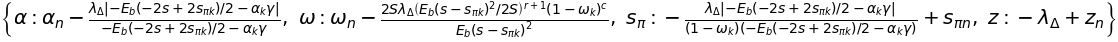

In [79]:
SV_n = sp.Matrix([sv.subs(subs_state_n) for sv in SV])
SV_k = sp.Matrix([sv.subs(subs_state_k) for sv in SV])
SV_k_expr =  SV_n + dlambda_ * signs * grad_psi_TF.subs(subs_TF).subs(subs_state_k)
subs_SV_k_expr = {
    sv: expr for sv, expr in zip(SV, list(SV_k_expr))
}
get_SV_k = sp.lambdify(
    (s, dlambda_, SV_n, SV_k), SV_k_expr.subs(material_params), 'numpy'
)
subs_SV_k_expr

In [80]:
SV_n, SV_k

⎛⎡sₚᵢ ₙ⎤  ⎡sₚᵢ ₖ⎤⎞
⎜⎢     ⎥  ⎢     ⎥⎟
⎜⎢ αₙ  ⎥  ⎢ αₖ  ⎥⎟
⎜⎢     ⎥, ⎢     ⎥⎟
⎜⎢ zₙ  ⎥  ⎢ zₖ  ⎥⎟
⎜⎢     ⎥  ⎢     ⎥⎟
⎝⎣ ωₙ  ⎦  ⎣ ωₖ  ⎦⎠

In [81]:
S_TF_SV = signs * TF_SV
S_TF_SV

⎡-E_b⋅(1 - ω)⋅(-2⋅s + 2⋅sₚᵢ) ⎤
⎢────────────────────────────⎥
⎢             2              ⎥
⎢                            ⎥
⎢            α⋅γ             ⎥
⎢                            ⎥
⎢            K⋅z             ⎥
⎢                            ⎥
⎢                    2       ⎥
⎢       E_b⋅(s - sₚᵢ)        ⎥
⎢       ──────────────       ⎥
⎣             2              ⎦

## Updating State Variables

In [82]:
S_TF_SV_usv = S_TF_SV.subs(subs_SV_k_expr)
S_TF_SV_usv1 =sp.simplify(S_TF_SV_usv)
S_TF_SV_usv1

⎡                                                                             
⎢                                                                             
⎢                                                                             
⎢(λ_Δ⋅│-E_b⋅(-s + sₚᵢ ₖ) - αₖ⋅γ│ + (ωₖ - 1)⋅(s - sₚᵢ ₙ)⋅(E_b⋅(-s + sₚᵢ ₖ) + αₖ
⎢                                                                             
⎢─────────────────────────────────────────────────────────────────────────────
⎢                                                                         2   
⎢                                                     (ωₖ - 1)⋅(s - sₚᵢ ₖ) ⋅(E
⎢                                                                             
⎢                                             γ⋅(αₙ⋅(-E_b⋅(s - sₚᵢ ₖ) + αₖ⋅γ) 
⎢                                             ────────────────────────────────
⎢                                                                 -E_b⋅(s - sₚ
⎢                                                   

In [105]:
get_TF_k = sp.lambdify(
    (s, SV), S_TF_SV.subs(material_params), 'numpy'
)
S_TF_SV.subs(material_params)

⎡-(1 - ω)⋅(-2⋅s + 2⋅sₚᵢ) ⎤
⎢────────────────────────⎥
⎢           2            ⎥
⎢                        ⎥
⎢         0.2⋅α          ⎥
⎢                        ⎥
⎢         0.1⋅z          ⎥
⎢                        ⎥
⎢                2       ⎥
⎢       (s - sₚᵢ)        ⎥
⎢       ──────────       ⎥
⎣           2            ⎦

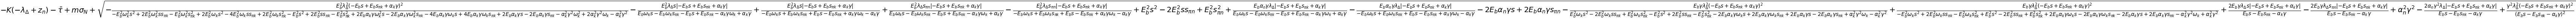

In [106]:
f_SV_k = f_SV.subs(subs_SV_k_expr)
get_f_SV_k = sp.lambdify(
    (s, dlambda_, SV_n, SV_k), f_SV_k.subs(material_params), 'numpy'
)
f_SV_k

In [85]:
d_f_SV_k = f_SV_k.diff(dlambda_)
get_d_f_SV_k = sp.lambdify(
    (s, dlambda_, SV_n, SV_k), d_f_SV_k.subs(material_params), 'numpy'
)
d_f_SV_k;

In [86]:
def get_response(s_max=12.6,n_steps=20):
    sv_n = np.zeros((len(SV),), dtype=np.float_)
    sv_k = np.zeros((len(SV),), dtype=np.float_)
    sv_record, tf_record, k_record = [], [], []
    k_max = 2000
    s_t = np.linspace(1e-9,s_max,n_steps+1)
    #print(s_t)
    for s_n in s_t: 
        dlambda0 = 0
        f0 = get_f_SV_k(s_n,dlambda0,sv_n,sv_k)
        norm_f0 = f0
        k = 0
        while k < k_max:
            if norm_f0 < 1e-10:
                sv_n = np.copy(sv_k)
                tf_n = get_TF_k(s_n,sv_n).flatten()
                sv_record.append(sv_n)
                tf_record.append(tf_n)
                k_record.append(k)
                break
            df0 = get_d_f_SV_k(s_n,dlambda0,sv_n,sv_k)
            dlambda0 -= f0/df0
            sv_k = get_SV_k(s_n,dlambda0,sv_n,sv_k).flatten()
            f0 = get_f_SV_k(s_n,dlambda0,sv_n,sv_k)
            norm_f0 = np.fabs(f0)
            k += 1
        else:
            print('no convergence')
    return (
        s_t, np.array(sv_record,dtype=np.float_),
        np.array(tf_record,dtype=np.float_),
        np.array(k_record,dtype=np.float_)
    )

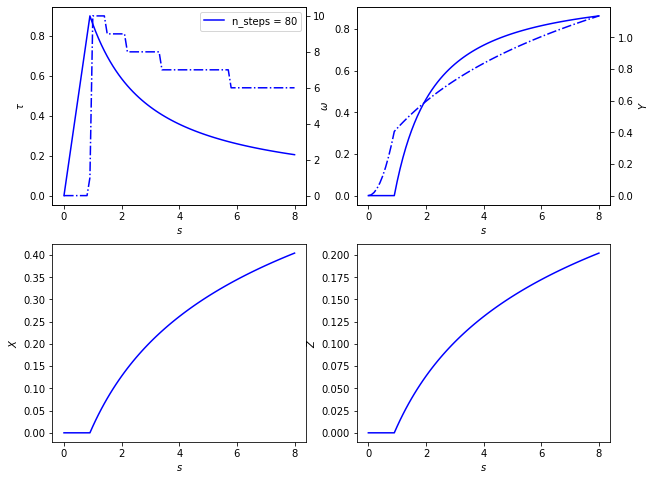

In [87]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(10,8))
ax11 = ax1.twinx()
ax22 = ax2.twinx()
colors = ['blue','red', 'green', 'black', 'magenta' ]
n_step_range = np.arange(1,2)*80
s_max = 8
for n_step, color in zip(n_step_range, colors):
    s_t, sv_arr, tf_arr, k_arr = get_response(s_max,n_step)
    #print((tf_arr[:,0]))
    ax1.plot(s_t, tf_arr[:,0], color=color, 
             label='n_steps = %g' % n_step)
    ax1.set_xlabel('$s$'); ax1.set_ylabel(r'$\tau$')
    ax1.legend()
    ax11.plot(s_t, k_arr[:], '-.', color=color )
    ax2.plot(s_t, sv_arr[:,3], color=color, 
             label='n_steps = %g' % n_step)
    ax2.set_xlabel('$s$'); ax2.set_ylabel(r'$\omega$')
    ax22.plot(s_t, tf_arr[:,3], '-.', color=color, 
             label='n_steps = %g' % n_step)
    ax22.set_ylabel('$Y$')
    ax3.plot(s_t, tf_arr[:,1], color=color, 
             label='n_steps = %g' % n_step)
    ax3.set_xlabel('$s$'); ax3.set_ylabel(r'$X$')
    ax4.plot(s_t, tf_arr[:,2], color=color, 
             label='n_steps = %g' % n_step)
    ax4.set_xlabel('$s$'); ax4.set_ylabel(r'$Z$')

## Consistent Tangent Operator

### Algorithmic Stiffness from the book

In [88]:
dlambda = f_SV_k / d_f_SV_k
dlam = dlambda.diff(s).doit()
dlam;

In [89]:
# dlambda = dot_lambda_simplified.diff(s).doit()
# dlam = sp.simplify(dlambda)
# dlam

In [98]:
#NEW Method 
diff_s = S_TF_SV_usv1[0].diff(dlambda_) 
s1 = diff_s * dlam
s1.subs(material_params);

In [91]:
# #NEW Method 
# diff_s = S_TF_SV_usv1[0].diff(s)
# diff_s_1 = sp.simplify(diff_s)
# s1.subs(material_params)

In [92]:
get_alg_stiffness = sp.lambdify((s, dlambda_,SV_n, SV_k), s1.subs(material_params), 'numpy')
get_alg_stiffness

<function _lambdifygenerated(s, lambda_Delta, _Dummy_213, _Dummy_214)>

### Secant Stiffnes

In [93]:
E_sec= sp.Symbol('E', real=True)
E_sec = (1-omega)*E_b
get_E_sec = sp.lambdify(
    (s, SV),E_sec.subs(material_params), 'numpy'
)
E_sec

### Algorithmic Stiffness from the Paper

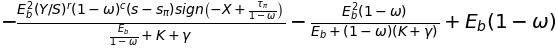

In [94]:
E= sp.Symbol('E', real=True)
E = (1 - omega) * E_b - ((1 - omega) * E_b**2) /(E_b +(gamma+K) * (1-omega))-((1 - omega)**c *E_b**2 * (s - s_pi) \
                            * (Y/S)** r * sp.sign(tau_pi/(1 - omega) - X))/(E_b/(1 - omega) + gamma + K)
get_E_stiff = sp.lambdify(
    (s, SV),E.subs(subs_TF).subs(material_params), 'numpy'
)
E 

In [95]:
def get_response(s_max=12.6,n_steps=100):
    sv_n = np.zeros((len(SV),), dtype=np.float_)
    sv_k = np.zeros((len(SV),), dtype=np.float_)
    sv_record, tf_record, k_record, alg_stiff_record, e_stiff_ppr, e_stiff_sec= [], [], [], [], [], []
    k_max = 2000
    s_t = np.linspace(1e-9,s_max,n_steps+1)
    for s_n in s_t:
        dlambda0 = 0
        f0 = get_f_SV_k(s_n,dlambda0,sv_n,sv_k)
        norm_f0 = f0 
        k = 0
        #dot_s = s_t[1]-s_t[0]
        while k < k_max:
            if norm_f0 < 1e-10:
                sv_n = np.copy(sv_k)
                tf_n = get_TF_k(s_n,sv_n).flatten() 
                algstiff = get_alg_stiffness(s_n,dlambda0, sv_n, sv_k).flatten()
                alg_stiff_record.append(algstiff)  
                E_stiff = get_E_stiff(s_n,sv_n).flatten()
                e_stiff_ppr.append(E_stiff)
                E_sec = get_E_sec(s_n,sv_n).flatten()
                e_stiff_sec.append(E_sec)
                sv_record.append(sv_n)
                tf_record.append(tf_n)
                k_record.append(k)
                break
            df0 = get_d_f_SV_k(s_n,dlambda0,sv_n,sv_k)
            dlambda0 -= f0/df0
            sv_k = get_SV_k(s_n,dlambda0,sv_n,sv_k).flatten()
            f0 = get_f_SV_k(s_n,dlambda0,sv_n,sv_k)
            norm_f0 = np.fabs(f0)
            k += 1
        else:
            print('no convergence')
    return (
        s_t, np.array(sv_record,dtype=np.float_),
        np.array(tf_record,dtype=np.float_),
        np.array(k_record,dtype=np.float_),
        np.array(alg_stiff_record,dtype=np.float_),
        np.array(e_stiff_ppr,dtype=np.float_),
        np.array(e_stiff_sec,dtype=np.float_)
    )

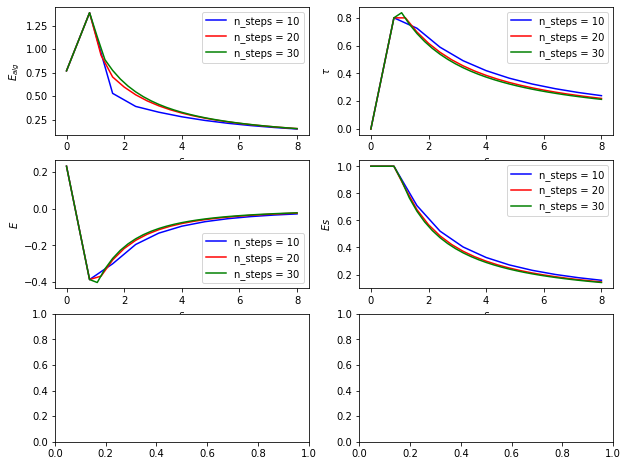

In [96]:
fig, ((ax1,ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(3,2,figsize=(10,8))
colors = ['blue','red', 'green', 'black', 'magenta' ]
n_step_range = np.arange(1,4)*10
s_max = 8
for n_step, color in zip(n_step_range, colors):
    s_t, sv_arr, tf_arr, k_arr, alg_arr, e_ppr, e_sec = get_response(s_max,n_step)
    ax1.plot(s_t, alg_arr[:], color=color, 
              label='n_steps = %g' % n_step)
    ax1.set_xlabel('$s$'); ax1.set_ylabel(r'$E_{alg}$')
    ax1.legend()
    ax2.plot(s_t, tf_arr[:,0], color=color, 
             label='n_steps = %g' % n_step)
    ax2.set_xlabel('$s$'); ax2.set_ylabel(r'$\tau$')
    ax2.legend()
    ax3.plot(s_t, e_ppr[:], color=color, 
             label='n_steps = %g' % n_step)
    ax3.set_xlabel('$s$'); ax3.set_ylabel('$E$')
    ax3.legend()
    ax4.plot(s_t, e_sec[:], color=color, 
             label='n_steps = %g' % n_step)
    ax4.set_xlabel('$s$'); ax4.set_ylabel('$Es$')
    ax4.legend()
f_name = os.path.join(home_dir,'m0.1gamma0.1K1.5112.pdf')
fig.savefig(f_name);